In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import collections

In [3]:
Observation = collections.namedtuple('Observation', ('state', 'action', 'reward', 'next_state', 'done'))

class DQN(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, 48)
        self.fc2 = nn.Linear(48, 48)
        self.fc3 = nn.Linear(48, n_outputs)
    def forward(self, x):        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class DQNSolver:
    GAMMA = 0.9
    BATCH_SIZE = 64
    REPLAY_MEMORY = 10000
    MIN_REPLAY_MEMORY = 1000
    def __init__(self, n_inputs, n_outputs):
      self.device = "cuda:0" if torch.cuda.is_available() else 'cpu'
      self.dqn = DQN(n_inputs, n_outputs).to(self.device)
      self.criterion  = torch.nn.MSELoss()
      self.num_actions = n_outputs
      self.opt = torch.optim.Adam(self.dqn.parameters(), lr = 0.001)
      self.replay_memory = collections.deque([], maxlen = 10000)
  
    def choose_action(self, state, epsilon):
        if (np.random.random() <= epsilon):
            return np.random.randint(self.num_actions)
        else:
            with torch.no_grad():
                return torch.argmax(self.dqn(state)).numpy()
    
    def remember(self, observation):
        #add past actions to deque memory
        self.replay_memory.append(observation)
        
    def replay(self):
        #take a random minibatch from memory - largeset minibatch size is given by batch_size
        #for each minibatch, y is the dqn action from state
        
        #reward is +1 for surviving another tick, +0 for not living
        if len(self.replay_memory) < self.MIN_REPLAY_MEMORY:
            return 0
        y_batch, y_target_batch = [], []
        minibatch = random.sample(self.replay_memory, self.BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            y = self.dqn(state)
            y_target = y.clone().detach()
            with torch.no_grad():
                y_target[0][action] = reward if done else reward + self.GAMMA * torch.max(self.dqn(next_state)[0])
            y_batch.append(y[0])
            y_target_batch.append(y_target[0])
        
        y_batch = torch.cat(y_batch)
        y_target_batch = torch.cat(y_target_batch)
        
        self.opt.zero_grad()
        loss = self.criterion(y_batch, y_target_batch)
        loss.backward()
        self.opt.step()        
        
        return loss.item()


if __name__=="__main__":
    env = gym.make("CartPole-v1")
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)

    epsilon_start = 1
    epsilon_end = 0.1
    epsilon_decay = 0.99
    epsilon = epsilon_start

    max_episodes = 1000
    episode = 0

    episode_runs = []
    episode_losses = []
    while episode < max_episodes:
        episode += 1
        state = env.reset()
        state = torch.tensor(np.reshape(state[0], [1, observation_space]))
        step = 0
        episode_loss = 0
        while True:
            step += 1
            action = dqn_solver.choose_action(state,epsilon)
            state_next, reward, terminal, truncated, info = env.step(action)
            reward = reward if not terminal else 0
            state_next = torch.tensor(np.reshape(state_next, [1, observation_space]))
            dqn_solver.remember(Observation(state, action, reward, state_next, terminal))
            loss = dqn_solver.replay()

            episode_loss += loss
            state = state_next
            if terminal or truncated:
                print("Run: " + str(episode) + ", score: " + str(step) + ", episode_loss: " + str(episode_loss/step))
                episode_runs.append(step)
                episode_losses.append(episode_loss/step)
                epsilon = epsilon * epsilon_decay
                epsilon = min(epsilon, epsilon_end)
                break

Run: 1, score: 15, episode_loss: 0.0
Run: 2, score: 10, episode_loss: 0.0
Run: 3, score: 9, episode_loss: 0.0
Run: 4, score: 11, episode_loss: 0.0
Run: 5, score: 9, episode_loss: 0.0
Run: 6, score: 8, episode_loss: 0.0
Run: 7, score: 9, episode_loss: 0.0
Run: 8, score: 10, episode_loss: 0.0
Run: 9, score: 11, episode_loss: 0.0
Run: 10, score: 9, episode_loss: 0.0
Run: 11, score: 13, episode_loss: 0.0
Run: 12, score: 9, episode_loss: 0.0
Run: 13, score: 10, episode_loss: 0.0
Run: 14, score: 10, episode_loss: 0.0
Run: 15, score: 9, episode_loss: 0.0
Run: 16, score: 10, episode_loss: 0.0
Run: 17, score: 10, episode_loss: 0.0
Run: 18, score: 10, episode_loss: 0.0
Run: 19, score: 10, episode_loss: 0.0
Run: 20, score: 9, episode_loss: 0.0
Run: 21, score: 11, episode_loss: 0.0
Run: 22, score: 10, episode_loss: 0.0
Run: 23, score: 10, episode_loss: 0.0
Run: 24, score: 10, episode_loss: 0.0
Run: 25, score: 10, episode_loss: 0.0
Run: 26, score: 9, episode_loss: 0.0
Run: 27, score: 8, episode_los

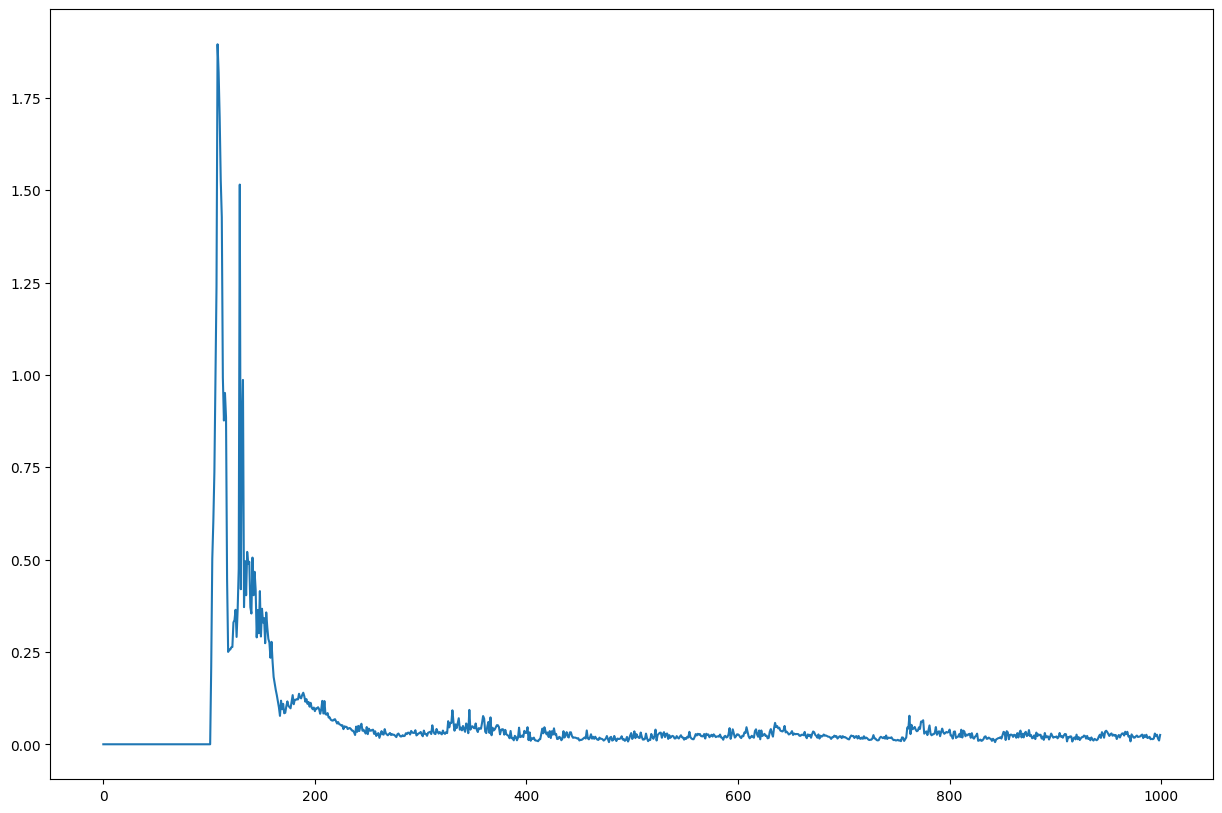

In [6]:
plt.figure(figsize = (15, 10))
plt.plot(episode_losses)

In [43]:
state = env.reset()
state = torch.tensor(np.reshape(state[0], [1, observation_space]))
step = 0
episode_loss = 0
while True:
    step += 1
    print(dqn_solver.dqn(state))
    action = dqn_solver.choose_action(state,epsilon)
    state_next, reward, terminal, truncated, info = env.step(action)
    reward = reward if not terminal else 0
    state_next = torch.tensor(np.reshape(state_next, [1, observation_space]))
    state = state_next
    if terminal or truncated:
        print("Run: " + str(episode) + ", score: " + str(step) + ", episode_loss: " + str(episode_loss/step))
    #     # episode_runs.append(step)
    #     # episode_losses.append(episode_loss/step)
    #     # epsilon = epsilon * epsilon_decay
    #     # epsilon = min(epsilon, epsilon_end)
        break

tensor([[10.0198, 10.0308]], grad_fn=<AddmmBackward0>)
tensor([[10.0076, 10.0128]], grad_fn=<AddmmBackward0>)
tensor([[9.9948, 9.9888]], grad_fn=<AddmmBackward0>)
tensor([[10.0088, 10.0090]], grad_fn=<AddmmBackward0>)
tensor([[9.9961, 9.9870]], grad_fn=<AddmmBackward0>)
tensor([[10.0096, 10.0054]], grad_fn=<AddmmBackward0>)
tensor([[10.0224, 10.0223]], grad_fn=<AddmmBackward0>)
tensor([[10.0350, 10.0404]], grad_fn=<AddmmBackward0>)
tensor([[10.0223, 10.0241]], grad_fn=<AddmmBackward0>)
tensor([[10.0099, 10.0064]], grad_fn=<AddmmBackward0>)
tensor([[10.0227, 10.0233]], grad_fn=<AddmmBackward0>)
tensor([[10.0102, 10.0057]], grad_fn=<AddmmBackward0>)
tensor([[10.0230, 10.0226]], grad_fn=<AddmmBackward0>)
tensor([[10.0355, 10.0408]], grad_fn=<AddmmBackward0>)
tensor([[10.0229, 10.0245]], grad_fn=<AddmmBackward0>)
tensor([[10.0104, 10.0069]], grad_fn=<AddmmBackward0>)
tensor([[10.0232, 10.0238]], grad_fn=<AddmmBackward0>)
tensor([[10.0107, 10.0062]], grad_fn=<AddmmBackward0>)
tensor([[10.02

In [22]:
dqn_solver.dqn(state)

tensor([[10.0225, 10.0181]], grad_fn=<AddmmBackward0>)